<a href="https://colab.research.google.com/github/benyaminemp/Optimisation/blob/main/Session1/Session1-Notebook3-ANNPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks - ANNs in PyTorch

# GPU in colab
First, you'll need to enable GPUs for the notebook:
*   Navigate to Edit→Notebook Settings
*   select GPU from the Hardware Accelerator list


# Importing Packages

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [3]:
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Callable

# Demonstration of the theory

# Importing Fashion MNIST dataset

In [5]:
def load_data(
    batch_size: int, validation_split: float
) -> tuple[DataLoader, DataLoader, DataLoader]:
    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # Convert the images to PyTorch tensors
        ]
    )

    # Create data loaders for the datasets

    full_train_dataset: datasets.FashionMNIST = datasets.FashionMNIST(
        root="data", train=True, download=True, transform=transform
    )
    test_dataset = datasets.FashionMNIST(
        root="data", train=False, download=True, transform=transform
    )

    # Calculate the sizes of each dataset
    train_size: int = int((1 - validation_split) * len(full_train_dataset))
    val_size: int = len(full_train_dataset) - train_size

    # Split the dataset
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size]
    )

    # Create data loaders
    train_loader: DataLoader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_loader: DataLoader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False
    )
    test_loader: DataLoader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return train_loader, val_loader, test_loader

In [6]:
train_loader, val_loader, test_loader = load_data(batch_size=64, validation_split=0.2)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.60MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
train_features, train_labels = next(iter(train_loader))

In [8]:
print(train_features.shape, train_labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


Checking the number of samples and dimensionality of images

The data represents images of

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

Checking the labels in training

In [9]:
unique_labels = train_labels.unique(sorted=True)
numb_labels = unique_labels.size()  # total number of labels
unique_labels

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
numb_labels[0]

10

Plotting images in different categories

In [11]:
def plot_unique_labels_with_categories(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    unique_labels: list[int],
    label_to_category: dict[int, str],
    nrows: int = 5,
    ncols: int = 2,
    figsize: tuple = (10, 15),
) -> None:
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()  # Flatten the axes array for easier indexing

    # Map unique labels to their corresponding image indices
    label_indices = {
        label.item(): (train_labels == label).nonzero(as_tuple=True)[0][0].item()
        for label in unique_labels
        if (train_labels == label).any()
    }

    for index, label in enumerate(unique_labels):
        if index >= len(ax):  # Prevent index errors if more labels than axes
            break
        if label.item() not in label_indices:  # Skip missing labels
            continue
        img_index = label_indices[label.item()]
        ax[index].imshow(train_features[img_index, 0, :, :].cpu(), cmap="gray")
        ax[index].set_title(f"{label_to_category[label.item()]}")
        ax[index].axis("off")

    # Turn off unused axes
    for index in range(len(unique_labels), len(ax)):
        ax[index].axis("off")

    plt.tight_layout()
    plt.show()

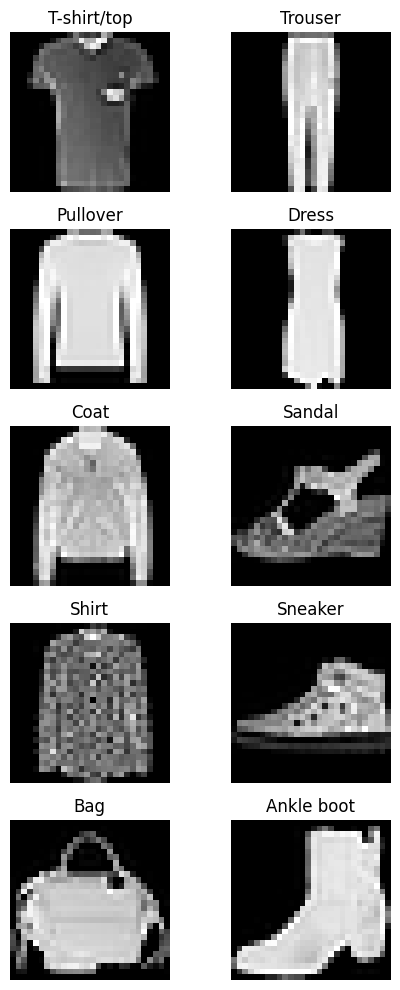

In [12]:
# Define the mapping of labels to category names
label_to_category = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


# Plot with category names
plot_unique_labels_with_categories(
    train_features,
    train_labels,
    unique_labels,
    label_to_category,
    nrows=5,
    ncols=2,
    figsize=(5, 10),
)

## Tensors - multidimensional arrays

Our images are grayscale, they are matrices so that each entry of a matrix is a pixel whose number represents the intensity of the colour,
- 0 represents black and
- 255 represents white.

We can think that grayscale images have only one colour channel, what about the colour images?

Colour may be important for a classification task.

Colour images are represented as 3 matrices,
- the first matrix is for RED channel, 255 represents RED and 0 BLACK;
- the second matrix is for GREEN channel, 255 represents GREEN and 0 BLACK;
- the third matrix is for the BLUE channel, 255 represents BLUE and 0 BLACK;

Rather than having 3 different matrices, we combain them into one array, we call this multidimensional array a tensor.

Given a colour image of size $p \times q$ the shape of the tensor will be

`` (p, q, 3) `` where 3 indicates that there are 3 colour channels.

Having $N$ colour images we will store tham in a tensor of the shape:

`` (N, p, q, 3)``

To get used to tensor structure let's convert our digits to tensor with 1 channel.


## Preprocessing an image

Later we will learn how to properly pre-process images. Now we will do a small tweak, as neural networks work better with numbers between 0 and 1, let's scale our images:

# Building a feedforward neural network for MNIST

For our neural networks we will set up a model as `nn.Module` sub-class.

Let's set up our model:



**Wait a second** We studied the neural networks so that their input was a vector, not a matrix or tensor.

To handle that we first add the FLATTENING layer, that will flatten the input so that it is a vector.

Now we add a couple of hidden-layers, these are called Linear layers in PyTorch.

In [13]:
class Model(nn.Module):
    def __init__(self, num_labels: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_one = nn.Linear(28 * 28, 32)
        self.dense_two = nn.Linear(32, 16)
        self.dense_three = nn.Linear(16, num_labels)
        self.relu = nn.ReLU()

    def forward(self, x_tensor: torch.Tensor) -> torch.Tensor:
        x_tensor = self.flatten(x_tensor)
        x_tensor = self.relu(self.dense_one(x_tensor))
        x_tensor = self.relu(self.dense_two(x_tensor))
        x_tensor = self.dense_three(x_tensor)
        return x_tensor

## Sequential API

Model can be prepared with sequential api, very similar the one knows from Keras (with TensorFlow backend).

In [14]:
num_labels: int = 10

model_seq = nn.Sequential(
    nn.Flatten(1, -1),  # Flatten the input
    nn.Linear(28 * 28, 32),  # Dense layer 1
    nn.ReLU(),  # Activation after dense layer 1
    nn.Linear(32, 16),  # Dense layer 2
    nn.ReLU(),  # Activation after dense layer 2
    nn.Linear(16, num_labels),  # Dense layer 3 (output layer)
)

Note that we choose an activation functino for this layers to be ReLU, remember $ReLU(x) = \max\{0, x\}$.

Now we will add the OUTPUT LAYER, it need to have the right number of nodes in the output to match the number of labels in Fashion MNIST.

We equipped the output layer with raw logits instead of the ``softmax`` activation function. This is because the loss function we use, ``CrossEntropyLoss``, internally applies ``logsoftmax`` to the logits. This approach ensures numerical stability and correct probability computations.

``LogSoftmax`` is a combination of the ``log`` and ``softmax`` functions, and it transforms the output vector into a log-probability distribution.

For a vector $z = (z_1, \ldots, z_n) \in \mathbb{R}^n$, the value of the softmax function $\sigma(z) = (\sigma(z)_1, \sigma(z)_2, \ldots, \sigma(z)_n)$ is given by:
$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^n e^{z_j}}$$

If we wish to define ``logsoftmax`` by hand, it is given by:
$$\log\sigma(z)_i = z_i - \log\left(\sum_{j=1}^n e^{z_j}\right)$$

This transformation ensures that each entry of the output vector is a valid log-probability. The highest log-probability cell corresponds to the digit prediction.


In [15]:
import numpy as np


def softmax(x):
    output = np.exp(x) / np.sum(np.exp(x))
    return output


def logsoftmax(x):
    return x - np.log(np.sum(np.exp(x)))


x = np.array([0.5, 1.0, 3.0])
print(softmax(x))
print(logsoftmax(x))

[0.06742536 0.11116562 0.82140902]
[-2.6967341 -2.1967341 -0.1967341]


### Selecting the LOSS function, the metrics for ACCURACY and the OPTIMIZER.

For classification problems we will pick **categorical cross-entropy** loss  function.

As score metrics we will pick **accuracy**.

For an optimizer let's use **STOCHASTIC GRADIENT DESCENT** (SGD).


In [16]:
num_labels: int = 10
model: Model = Model(num_labels)

criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: optim.SGD = optim.SGD(model.parameters(), lr=0.01)

In [17]:
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Flatten: 1-1                           --
├─Linear: 1-2                            25,120
├─Linear: 1-3                            528
├─Linear: 1-4                            170
├─ReLU: 1-5                              --
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0

In [18]:
summary(model_seq)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            25,120
├─ReLU: 1-3                              --
├─Linear: 1-4                            528
├─ReLU: 1-5                              --
├─Linear: 1-6                            170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0

# Training the Network

Let's select a number of epochs, let's set it for 5 to beging with.

In [19]:
EPOCHS = 5

In [20]:
# Define a function to train for one epoch
def train_one_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> tuple[float, float]:
    model.train()
    total_loss: float = 0.0
    total_samples: int = 0
    correct_predictions: int = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs: torch.Tensor = model(inputs)

        # Compute loss
        loss: torch.Tensor = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        _, predicted_labels = torch.max(outputs, dim=1)
        total_samples += targets.size(0)
        correct_predictions += (predicted_labels == targets).sum().item()

        # Update running loss
        total_loss += loss.item()

    average_loss: float = total_loss / len(train_loader)
    accuracy: float = (correct_predictions / total_samples) * 100
    return average_loss, accuracy

In [21]:
# Define a function to evaluate the model on the validation set
def evaluate_model(
    model: nn.Module, val_loader: DataLoader, criterion: nn.Module, device: torch.device
) -> tuple[float, float, list[int], list[int]]:
    model.eval()
    total_loss: float = 0.0
    total_samples: int = 0
    correct_predictions: int = 0
    y_true: list[int] = []
    y_pred: list[int] = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs: torch.Tensor = model(inputs)
            loss: torch.Tensor = criterion(outputs, targets)

            _, predicted_labels = torch.max(outputs, dim=1)
            y_true.extend(targets.cpu().tolist())
            y_pred.extend(predicted_labels.cpu().tolist())

            total_samples += targets.size(0)
            correct_predictions += (predicted_labels == targets).sum().item()
            total_loss += loss.item()

    average_loss: float = total_loss / len(val_loader)
    accuracy: float = (correct_predictions / total_samples) * 100
    return average_loss, accuracy, y_pred, y_true

In [22]:
# Define a function to train the model for multiple epochs
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
) -> tuple[list[float], list[float], list[float], list[float]]:
    training_loss_history: list[float] = []
    training_accuracy_history: list[float] = []
    validation_loss_history: list[float] = []
    validation_accuracy_history: list[float] = []

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_accuracy = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_accuracy, _, _ = evaluate_model(
            model, val_loader, criterion, device
        )

        training_loss_history.append(train_loss)
        training_accuracy_history.append(train_accuracy)
        validation_loss_history.append(val_loss)
        validation_accuracy_history.append(val_accuracy)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
            f"Val Accuracy: {val_accuracy:.2f}%"
        )

    return (
        training_loss_history,
        training_accuracy_history,
        validation_loss_history,
        validation_accuracy_history,
    )

Now we will fit the model

In [23]:
(
    training_loss_history,
    training_accuracy_history,
    validation_loss_history,
    validation_accuracy_history,
) = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, device)

Epoch 1/5, Train Loss: 1.6609, Val Loss: 0.9771, Training Accuracy: 48.58%, Val Accuracy: 64.83%
Epoch 2/5, Train Loss: 0.8280, Val Loss: 0.7235, Training Accuracy: 68.71%, Val Accuracy: 73.57%
Epoch 3/5, Train Loss: 0.6793, Val Loss: 0.6203, Training Accuracy: 75.98%, Val Accuracy: 78.82%
Epoch 4/5, Train Loss: 0.6031, Val Loss: 0.5776, Training Accuracy: 79.31%, Val Accuracy: 79.52%
Epoch 5/5, Train Loss: 0.5573, Val Loss: 0.5312, Training Accuracy: 80.77%, Val Accuracy: 81.64%


# Model summary

We can display the model structure, it will also show us how many parameters (weights, biases) there is for the training.

In [24]:
summary(model)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Flatten: 1-1                           --
├─Linear: 1-2                            25,120
├─Linear: 1-3                            528
├─Linear: 1-4                            170
├─ReLU: 1-5                              --
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0

# Plotting TRAINING AND VALIDATION curves

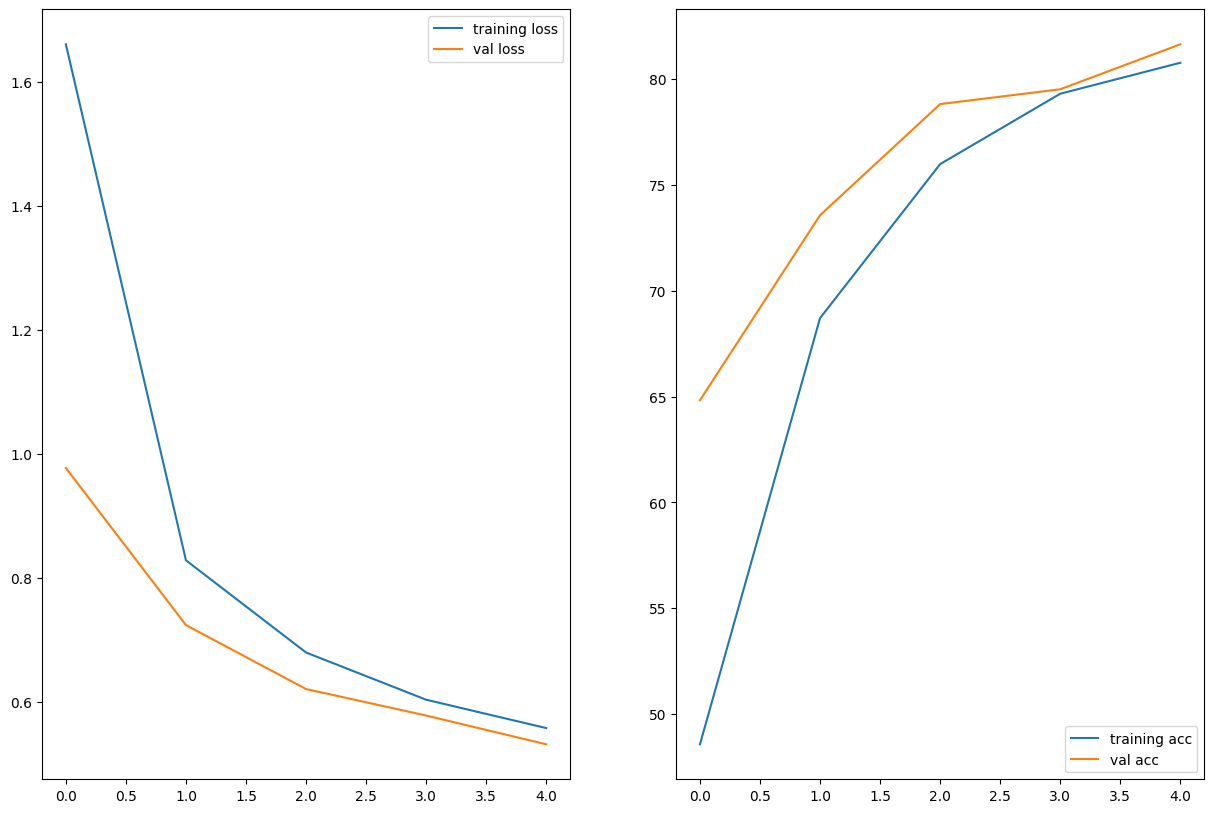

In [25]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(training_loss_history, label="training loss")
plt.plot(validation_loss_history, label="val loss")
plt.legend(loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(training_accuracy_history, label="training acc")
plt.plot(validation_accuracy_history, label="val acc")
plt.legend(loc="lower right")

plt.show()

## Evaluating the model

In [26]:
loss, accuracy, y_pred, y_true = evaluate_model(model, test_loader, criterion, device)

print(f"Test accuracy: {accuracy}")

Test accuracy: 80.08


# Confusion matrix

We produce the confusion matrix of our model.

A **confusion matrix** contains a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class.

In [27]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [28]:
def plot_confusion_matrix(y_true: list[int], y_pred: list[int]) -> np.ndarray:
    conf_matrix = confusion_matrix(y_true, y_pred)
    index_conf = np.arange(conf_matrix.shape[0])
    df_cm = pd.DataFrame(conf_matrix, index_conf, index_conf)
    plt.figure(figsize=(15, 10))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="g")
    plt.show()
    return conf_matrix

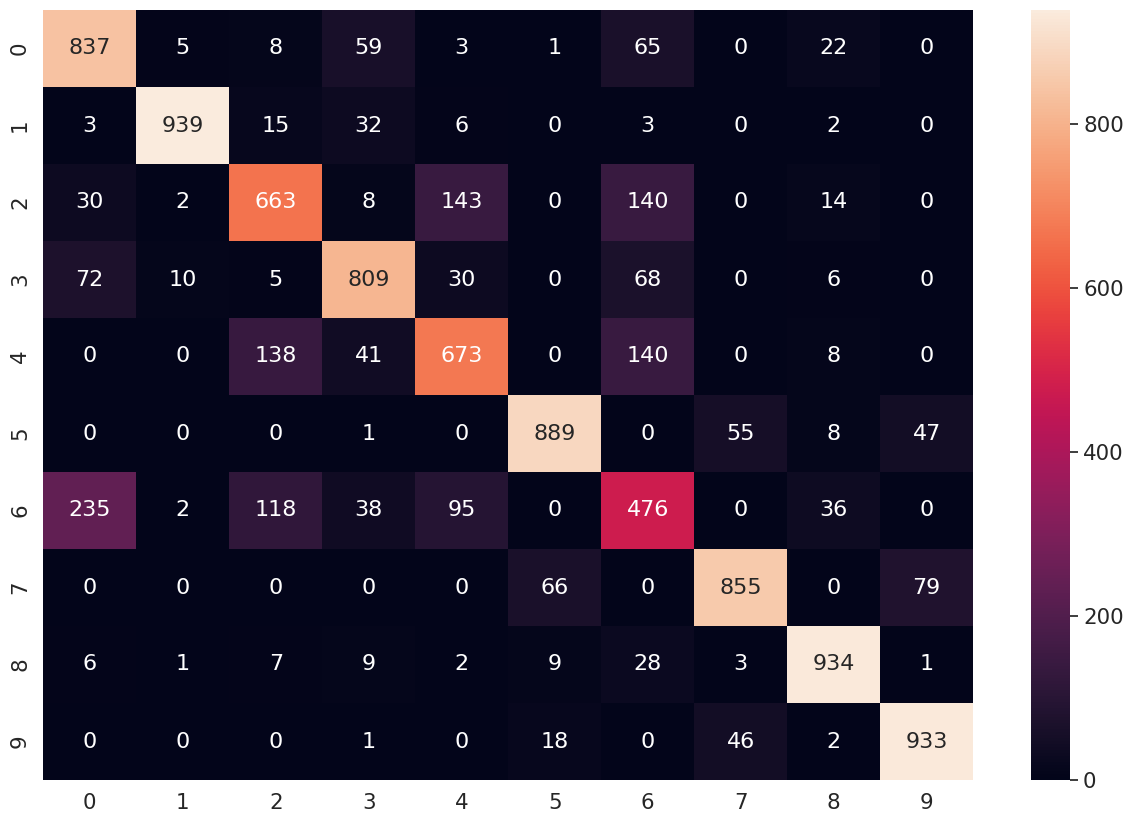

array([[837,   5,   8,  59,   3,   1,  65,   0,  22,   0],
       [  3, 939,  15,  32,   6,   0,   3,   0,   2,   0],
       [ 30,   2, 663,   8, 143,   0, 140,   0,  14,   0],
       [ 72,  10,   5, 809,  30,   0,  68,   0,   6,   0],
       [  0,   0, 138,  41, 673,   0, 140,   0,   8,   0],
       [  0,   0,   0,   1,   0, 889,   0,  55,   8,  47],
       [235,   2, 118,  38,  95,   0, 476,   0,  36,   0],
       [  0,   0,   0,   0,   0,  66,   0, 855,   0,  79],
       [  6,   1,   7,   9,   2,   9,  28,   3, 934,   1],
       [  0,   0,   0,   1,   0,  18,   0,  46,   2, 933]])

In [29]:
conf_matrix = plot_confusion_matrix(y_true, y_pred)  # confusion matrix
conf_matrix